In [96]:
import pandas as pd
import glob
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import pacf
from pmdarima.arima import auto_arima

In [98]:
data = pd.read_csv('H4_EURUSD_parsed.csv', parse_dates=['Time'], index_col='Time', header=0,sep=",")
data.head()

,open,high,low,close
Time,,,,
2000-01-01 02:00:00,1.0088,1.0106,1.0061,1.0062
2000-01-03 06:00:00,1.0073,1.0190,1.0073,1.0175
2000-01-03 10:00:00,1.0173,1.0181,1.0154,1.0157
2000-01-03 14:00:00,1.0154,1.0167,1.0093,1.0115
2000-01-03 18:00:00,1.0118,1.0118,1.0054,1.0073


In [99]:
data.drop(['open','high','low'],axis=1,inplace=True)

<Axes: xlabel='Time'>

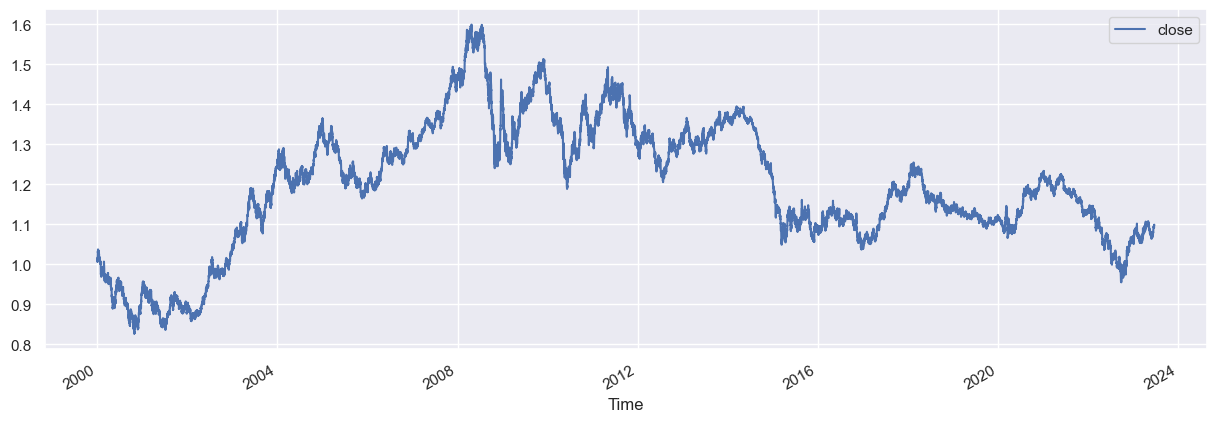

In [100]:
data.plot(figsize=(15,5))

In [101]:
TEST_SIZE = 1000
train, test = data.iloc[:-TEST_SIZE], data.iloc[-TEST_SIZE:]
x_train, x_test = np.array(range(train.shape[0])), np.array(range(train.shape[0], data.shape[0]))
train.shape, x_train.shape, test.shape, x_test.shape

((35561, 1), (35561,), (1000, 1), (1000,))

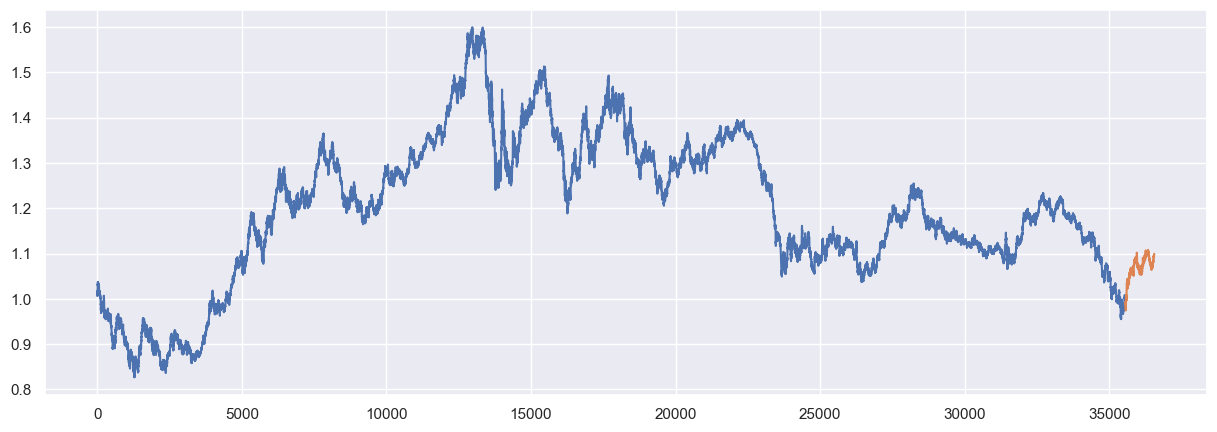

In [102]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, train)
ax.plot(x_test, test)

In [103]:
model = auto_arima(train, start_p=1, start_q=1,
                      test='adf',
                      max_p=5, max_q=5,
                      m=1,             
                      d=1,          
                      seasonal=False,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-313683.777, Time=10.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-313687.784, Time=2.90 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-313686.295, Time=4.77 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-313686.291, Time=5.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-313689.783, Time=0.85 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 24.118 seconds


In [104]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                35561
Model:               SARIMAX(0, 1, 0)   Log Likelihood              156845.891
Date:                Mon, 26 Jun 2023   AIC                        -313689.783
Time:                        17:37:17   BIC                        -313681.304
Sample:                             0   HQIC                       -313687.084
                              - 35561                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.638e-06   2.98e-08    289.403      0.000    8.58e-06     8.7e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.51   Jarque-Bera (JB):             81590.20
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               0.74   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [84]:
# Forecast

prediction, confint = model.predict(n_periods=TEST_SIZE, return_conf_int=True)

prediction

C:\Users\iftek\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\iftek\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


35561    0.99341
35562    0.99341
35563    0.99341
35564    0.99341
35565    0.99341
          ...   
36556    0.99341
36557    0.99341
36558    0.99341
36559    0.99341
36560    0.99341
Length: 1000, dtype: float64

In [105]:
cf= pd.DataFrame(confint)

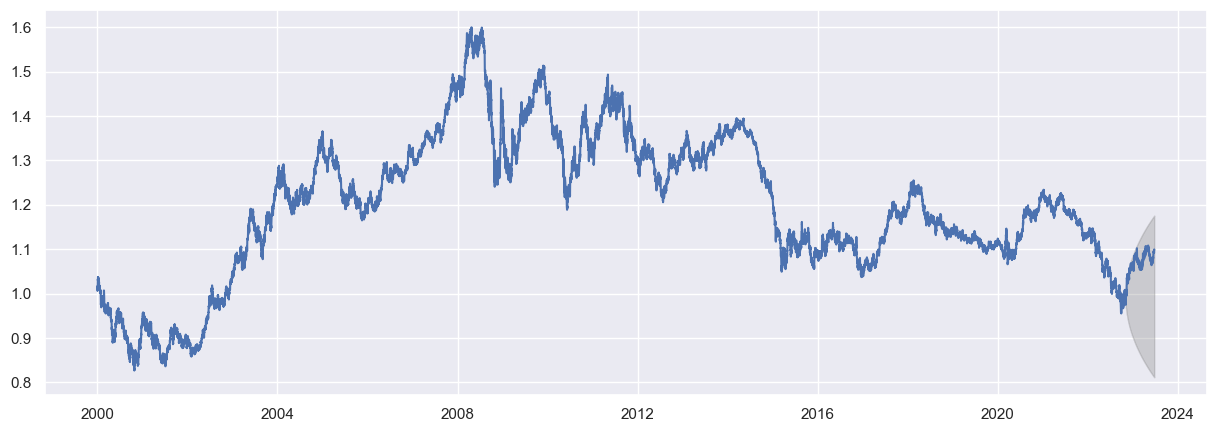

In [106]:
#Mostramos la gráfica con la predicción de los 2 últimos años en naranja
#sobre la serie real 
prediction_series = pd.Series(prediction,index=test.index)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(data.close)
ax.plot(prediction_series)
ax.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.3)

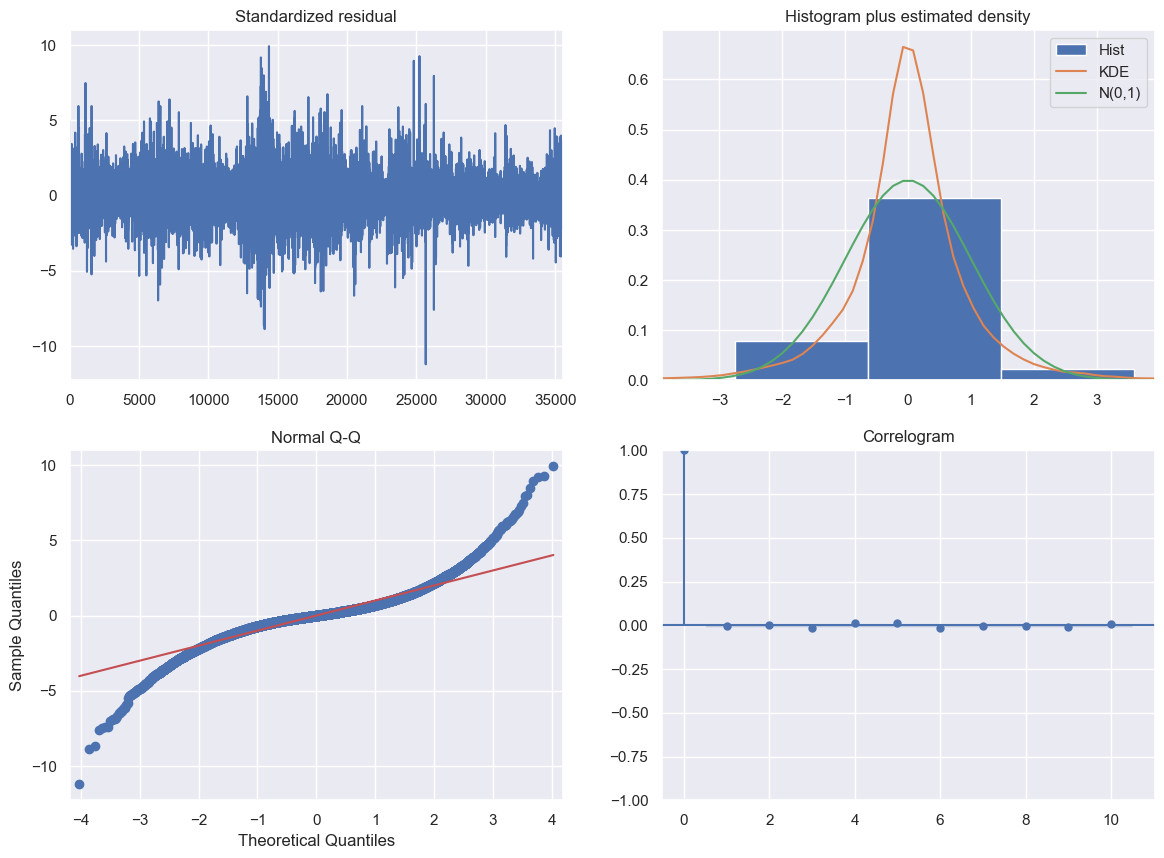

In [107]:
model.plot_diagnostics(figsize=(14,10))
plt.show()

In [108]:
def calcsmape(actual, forecast):
    return 1/len(actual) * np.sum(2 * np.abs(forecast-actual) / (np.abs(actual) + np.abs(forecast)))


In [117]:
smape=calcsmape(test.close,prediction)
smape

0.0

In [123]:
data = data[-1000:]

In [124]:
data

,close
Time,
2022-11-01 18:00:00,0.99359
2022-11-01 22:00:00,0.98822
2022-11-02 02:00:00,0.98748
2022-11-02 06:00:00,0.98882
2022-11-02 10:00:00,0.98877
...,...
2023-06-22 02:00:00,1.09856
2023-06-22 06:00:00,1.09886
2023-06-22 10:00:00,1.09872


In [127]:
TEST_SIZE = 100
train, test = data.iloc[:-TEST_SIZE], data.iloc[-TEST_SIZE:]
x_train, x_test = np.array(range(train.shape[0])), np.array(range(train.shape[0], data.shape[0]))
train.shape, x_train.shape, test.shape, x_test.shape

((900, 1), (900,), (100, 1), (100,))

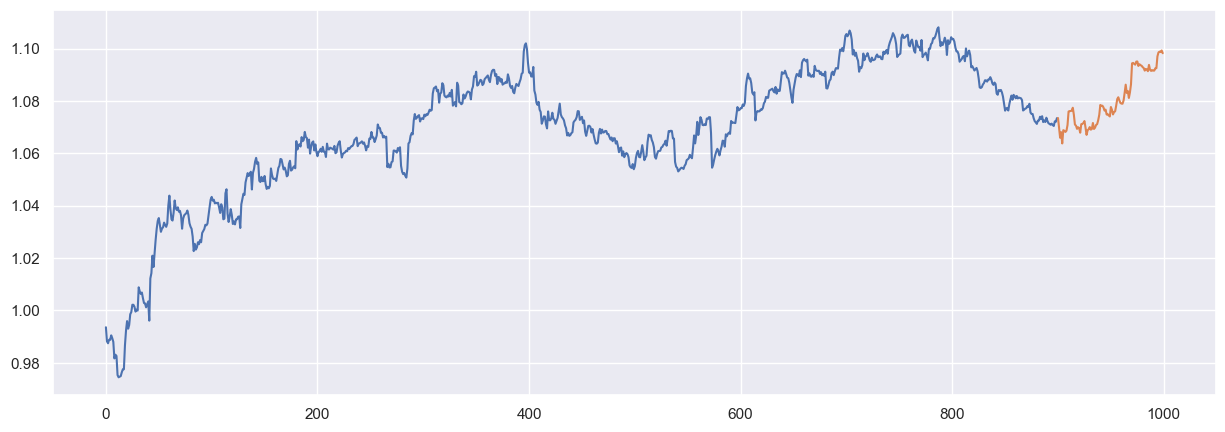

In [128]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, train)
ax.plot(x_test, test)

In [129]:
model = auto_arima(train, start_p=1, start_q=1,
                      test='adf',
                      max_p=5, max_q=5,
                      m=1,             
                      d=1,          
                      seasonal=False,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-8205.009, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8208.522, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8206.965, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-8206.975, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-8209.398, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.409 seconds


In [130]:
prediction, confint = model.predict(n_periods=TEST_SIZE, return_conf_int=True)

prediction

C:\Users\iftek\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\iftek\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


900    1.07346
901    1.07346
902    1.07346
903    1.07346
904    1.07346
        ...   
995    1.07346
996    1.07346
997    1.07346
998    1.07346
999    1.07346
Length: 100, dtype: float64

In [131]:
cf= pd.DataFrame(confint)

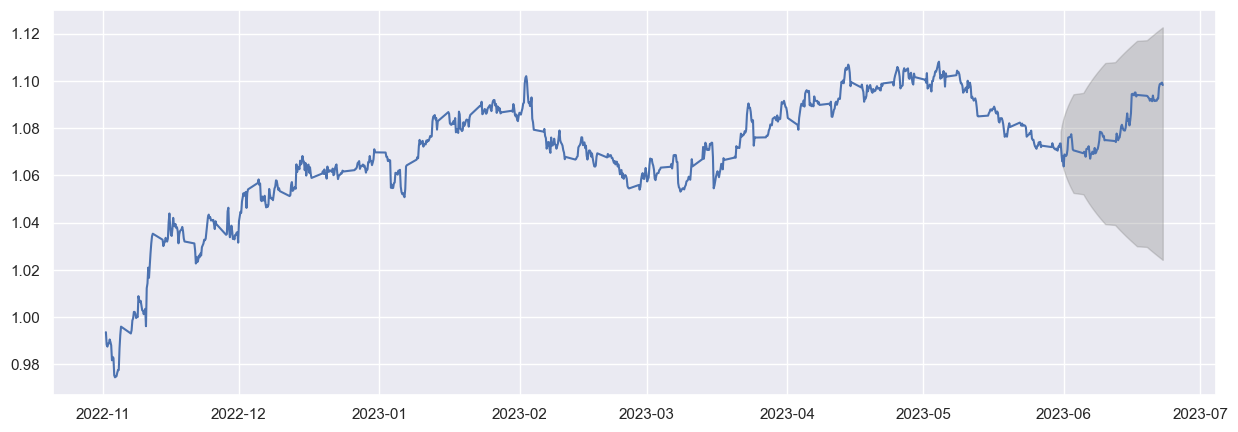

In [133]:
prediction_series = pd.Series(prediction,index=test.index)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(data.close)
ax.plot(prediction_series, color='red')
ax.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.3)

In [134]:
smape=calcsmape(test.close,prediction)
smape

0.0

In [48]:
import pandas as pd
import numpy as np
from scalecast.Forecaster import Forecaster
from scalecast.auxmodels import auto_arima
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from datetime import datetime

In [ ]:
 parse_dates=['TIME'], index_col='TIME',

In [54]:
df = pd.read_csv('H4_EURUSD.csv', usecols=['Time', 'close', 'open', 'high', 'low'])

In [63]:
df.to_csv('H4_EURUSD_parsed.csv')

In [61]:
df.set_index('Time', inplace=True)

In [57]:
df['Date'] = df.Time.apply(lambda x: datetime.fromtimestamp(x))

TypeError: 'str' object cannot be interpreted as an integer

In [60]:
df['Date'] = df.Time.apply(lambda x: x.date())

AttributeError: 'str' object has no attribute 'date'